# Assignment 5 - Reinforcement Learning

## *Joaquin Menendez*
Netid:  *jm622*

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [294]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    def Usable_Ace(self,ace = True):   #Small modification to make easier to code the without ace part
        self.Usable_Ace = ace
        return Usable_Ace
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.Usable_Ace = True
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        if self.Usable_Ace == True:
            return 1 in hand and sum(hand) + 10 <= 21
        else: 
            return False
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [2]:
import numpy as np

# Initialize the class:
game = Blackjack()
game.Usable_Ace = False# Small modification to make the nex exercise easier

# Deal the cards:
s0 = game.deal()
print(s0)
print(game.player)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
s1 = game.step(1)
print(s1)
print(game.player)

# If you wanted to stay:
s2 = game.step(2)
print(s2)
# When it's gameover, just redeal:
# game.deal()

print(game._get_obs())


(6, 2, False)
[4, 2]
((13, 2, False), 0, False)
[4, 2, 7]
((13, 2, False), 1.0, True)
(13, 2, False)


**ANSWER**

In [11]:
hands = []
game = Blackjack()

for n in range(0,50):    
    hands.append(game.deal())
    print('Hand number: %d' % (n+1))
    print(hands[n])
    decision = 0
    value = 0
    while decision != 2 and value <= 21:
        decision = int(input('Continue (1) or step (2)?: '))
        if decision == 2:
            hands[n] = game.step(2)
            print(hands[n])
            value = hands[n][0][0]
            break
        elif decision == 1:
            hands[n] = game.step(1)
            print(hands[n])
            value = hands[n][0][0]

Hand number: 1
(18, 1, False)


Continue (1) or step (2)?:  2


((18, 1, False), -1.0, True)
Hand number: 2
(6, 7, False)


Continue (1) or step (2)?:  1


((9, 7, False), 0, False)


Continue (1) or step (2)?:  1


((12, 7, False), 0, False)


Continue (1) or step (2)?:  1


((22, 7, False), -1, True)
Hand number: 3
(11, 2, False)


Continue (1) or step (2)?:  1


((20, 2, False), 0, False)


Continue (1) or step (2)?:  2


((20, 2, False), -1.0, True)
Hand number: 4
(11, 6, False)


Continue (1) or step (2)?:  1


((14, 6, False), 0, False)


Continue (1) or step (2)?:  1


((17, 6, False), 0, False)


Continue (1) or step (2)?:  2


((17, 6, False), 1.0, True)
Hand number: 5
(12, 10, False)


Continue (1) or step (2)?:  1


((17, 10, False), 0, False)


Continue (1) or step (2)?:  2


((17, 10, False), -1.0, True)
Hand number: 6
(20, 8, False)


Continue (1) or step (2)?:  2


((20, 8, False), 1.0, True)
Hand number: 7
(20, 4, True)


Continue (1) or step (2)?:  2


((20, 4, True), 1.0, True)
Hand number: 8
(15, 4, False)


Continue (1) or step (2)?:  1


((24, 4, False), -1, True)
Hand number: 9
(5, 4, False)


Continue (1) or step (2)?:  1


((13, 4, False), 0, False)


Continue (1) or step (2)?:  1


((21, 4, False), 0, False)


Continue (1) or step (2)?:  2


((21, 4, False), 1.0, True)
Hand number: 10
(13, 10, False)


Continue (1) or step (2)?:  1


((23, 10, False), -1, True)
Hand number: 11
(4, 1, False)


Continue (1) or step (2)?:  1


((6, 1, False), 0, False)


Continue (1) or step (2)?:  1


((16, 1, False), 0, False)


Continue (1) or step (2)?:  1


((23, 1, False), -1, True)
Hand number: 12
(11, 10, False)


Continue (1) or step (2)?:  1


((16, 10, False), 0, False)


Continue (1) or step (2)?:  1


((25, 10, False), -1, True)
Hand number: 13
(18, 10, False)


Continue (1) or step (2)?:  1


((27, 10, False), -1, True)
Hand number: 14
(14, 1, False)


Continue (1) or step (2)?:  1


((15, 1, False), 0, False)


Continue (1) or step (2)?:  1


((24, 1, False), -1, True)
Hand number: 15
(14, 10, False)


Continue (1) or step (2)?:  1


((17, 10, False), 0, False)


Continue (1) or step (2)?:  2


((17, 10, False), -1.0, True)
Hand number: 16
(17, 10, False)


Continue (1) or step (2)?:  2


((17, 10, False), 0.0, True)
Hand number: 17
(15, 4, False)


Continue (1) or step (2)?:  1


((25, 4, False), -1, True)
Hand number: 18
(10, 9, False)


Continue (1) or step (2)?:  1


((17, 9, False), 0, False)


Continue (1) or step (2)?:  2


((17, 9, False), 1.0, True)
Hand number: 19
(18, 10, True)


Continue (1) or step (2)?:  2


((18, 10, True), -1.0, True)
Hand number: 20
(18, 2, False)


Continue (1) or step (2)?:  2


((18, 2, False), 1.0, True)
Hand number: 21
(11, 9, False)


Continue (1) or step (2)?:  1


((16, 9, False), 0, False)


Continue (1) or step (2)?:  1


((26, 9, False), -1, True)
Hand number: 22
(14, 8, False)


Continue (1) or step (2)?:  1


((24, 8, False), -1, True)
Hand number: 23
(14, 9, False)


Continue (1) or step (2)?:  1


((22, 9, False), -1, True)
Hand number: 24
(12, 3, True)


Continue (1) or step (2)?:  1


((14, 3, True), 0, False)


Continue (1) or step (2)?:  1


((12, 3, False), 0, False)


Continue (1) or step (2)?:  1


((17, 3, False), 0, False)


Continue (1) or step (2)?:  2


((17, 3, False), -1.0, True)
Hand number: 25
(8, 9, False)


Continue (1) or step (2)?:  1


((16, 9, False), 0, False)


Continue (1) or step (2)?:  1


((17, 9, False), 0, False)


Continue (1) or step (2)?:  2


((17, 9, False), -1.0, True)
Hand number: 26
(10, 3, False)


Continue (1) or step (2)?:  1


((15, 3, False), 0, False)


Continue (1) or step (2)?:  1


((25, 3, False), -1, True)
Hand number: 27
(18, 2, False)


Continue (1) or step (2)?:  2


((18, 2, False), 0.0, True)
Hand number: 28
(9, 10, False)


Continue (1) or step (2)?:  1


((11, 10, False), 0, False)


Continue (1) or step (2)?:  1


((14, 10, False), 0, False)


Continue (1) or step (2)?:  1


((24, 10, False), -1, True)
Hand number: 29
(7, 3, False)


Continue (1) or step (2)?:  1


((16, 3, False), 0, False)


Continue (1) or step (2)?:  2


((16, 3, False), 1.0, True)
Hand number: 30
(5, 2, False)


Continue (1) or step (2)?:  1


((13, 2, False), 0, False)


Continue (1) or step (2)?:  1


((18, 2, False), 0, False)


Continue (1) or step (2)?:  2


((18, 2, False), -1.0, True)
Hand number: 31
(19, 10, False)


Continue (1) or step (2)?:  2


((19, 10, False), 1.0, True)
Hand number: 32
(12, 10, False)


Continue (1) or step (2)?:  1


((19, 10, False), 0, False)


Continue (1) or step (2)?:  2


((19, 10, False), -1.0, True)
Hand number: 33
(21, 10, True)


Continue (1) or step (2)?:  2


((21, 10, True), 1.0, True)
Hand number: 34
(11, 5, False)


Continue (1) or step (2)?:  1


((14, 5, False), 0, False)


Continue (1) or step (2)?:  1


((24, 5, False), -1, True)
Hand number: 35
(21, 9, True)


Continue (1) or step (2)?:  2


((21, 9, True), 1.0, True)
Hand number: 36
(20, 2, False)


Continue (1) or step (2)?:  2


((20, 2, False), 0.0, True)
Hand number: 37
(12, 9, False)


Continue (1) or step (2)?:  1


((13, 9, False), 0, False)


Continue (1) or step (2)?:  1


((22, 9, False), -1, True)
Hand number: 38
(12, 6, False)


Continue (1) or step (2)?:  1


((16, 6, False), 0, False)


Continue (1) or step (2)?:  2


((16, 6, False), -1.0, True)
Hand number: 39
(12, 2, False)


Continue (1) or step (2)?:  1


((15, 2, False), 0, False)


Continue (1) or step (2)?:  1


((19, 2, False), 0, False)


Continue (1) or step (2)?:  2


((19, 2, False), 1.0, True)
Hand number: 40
(13, 10, False)


Continue (1) or step (2)?:  1


((23, 10, False), -1, True)
Hand number: 41
(12, 10, False)


Continue (1) or step (2)?:  1


((22, 10, False), -1, True)
Hand number: 42
(21, 6, True)


Continue (1) or step (2)?:  2


((21, 6, True), 1.0, True)
Hand number: 43
(10, 9, False)


Continue (1) or step (2)?:  1


((12, 9, False), 0, False)


Continue (1) or step (2)?:  1


((13, 9, False), 0, False)


Continue (1) or step (2)?:  1


((14, 9, False), 0, False)


Continue (1) or step (2)?:  2


((14, 9, False), -1.0, True)
Hand number: 44
(9, 10, False)


Continue (1) or step (2)?:  1


((14, 10, False), 0, False)


Continue (1) or step (2)?:  1


((20, 10, False), 0, False)


Continue (1) or step (2)?:  2


((20, 10, False), 0.0, True)
Hand number: 45
(12, 10, False)


Continue (1) or step (2)?:  1


((19, 10, False), 0, False)


Continue (1) or step (2)?:  2


((19, 10, False), -1.0, True)
Hand number: 46
(12, 2, False)


Continue (1) or step (2)?:  2


((12, 2, False), -1.0, True)
Hand number: 47
(12, 5, False)


Continue (1) or step (2)?:  1


((13, 5, False), 0, False)


Continue (1) or step (2)?:  2


((13, 5, False), 1.0, True)
Hand number: 48
(15, 10, False)


Continue (1) or step (2)?:  2


((15, 10, False), -1.0, True)
Hand number: 49
(14, 8, False)


Continue (1) or step (2)?:  1


((22, 8, False), -1, True)
Hand number: 50
(8, 7, False)


Continue (1) or step (2)?:  1


((13, 7, False), 0, False)


Continue (1) or step (2)?:  1


((14, 7, False), 0, False)


Continue (1) or step (2)?:  1


((24, 7, False), -1, True)


In [217]:
reward = 0
for hand in hands:
    reward += hand[1]
print('Total reward won: %d' %reward)
print('Average reward won: %.2f' %(reward/50.0))

Total reward won: -20
Average reward won: -0.40


The data show that my average reward is negative. This indicate that my human policy did not followed the optimal action value. 

## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Relwat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

In [295]:
def Play_Blackjack(number_trials = 10000, Usable_Ace = True):
    #Defining containers for data
    player_hands = np.zeros((21,number_trials)) # Matrix with all the rewards for each state(row) for every trial(columns). Just to have more detailed data
    dealer_hands = np.zeros((10,number_trials))
    outcome_matrix =  np.zeros((21,10)) # Row player cards, column dealer cards. Number of times a combination appear
    reward_matrix = np.zeros((21,10))  # Idem. Sum of rewards for each combination.
    #initialize object
    game = Blackjack()
    game.Usable_Ace = Usable_Ace # With usable aces or not
        
    for trial in range(0,number_trials):
        game.deal()
        player_card,dealer_card = game._get_obs()[0:2]
        if player_card == 22: continue  #to prevent to continue with 2 aces
        row_player = player_card - 1
        row_dealer= dealer_card - 1  
        #print(game.player, '\t',player_card,'/',dealer_card,'/', row_player,'/', row_dealer)
        outcome_matrix[row_player,row_dealer] += 1
        while player_card <= 19:
            game.step(1)
            player_card = game._get_obs()[0]

        reward = game.step(2)[1]
        player_hands[row_player,trial] = reward
        dealer_hands[row_dealer,trial] = reward
        reward_matrix[row_player,row_dealer] += reward
    prob_reward_matrix = reward_matrix/outcome_matrix    
    return  prob_reward_matrix,outcome_matrix, reward_matrix, dealer_hands , player_hands

In [296]:
#import warnings; warnings.simplefilter('ignore')
prob_reward_matrix_1ace,outcome_matrix, reward_matrix, dealer_hands , player_hands_10000 = Play_Blackjack(number_trials=10000, Usable_Ace=True)
prob_reward_matrix_5ace ,_,_,_,player_hands_500000 = Play_Blackjack(number_trials=500000,Usable_Ace=True)

In [297]:
prob_reward_matrix_1noace,outcome_matrix, reward_matrix, dealer_hands , player_hands = Play_Blackjack(number_trials=10000, Usable_Ace=False)
prob_reward_matrix_5noace ,_,_,_,_ = Play_Blackjack(number_trials=500000,  Usable_Ace=False)

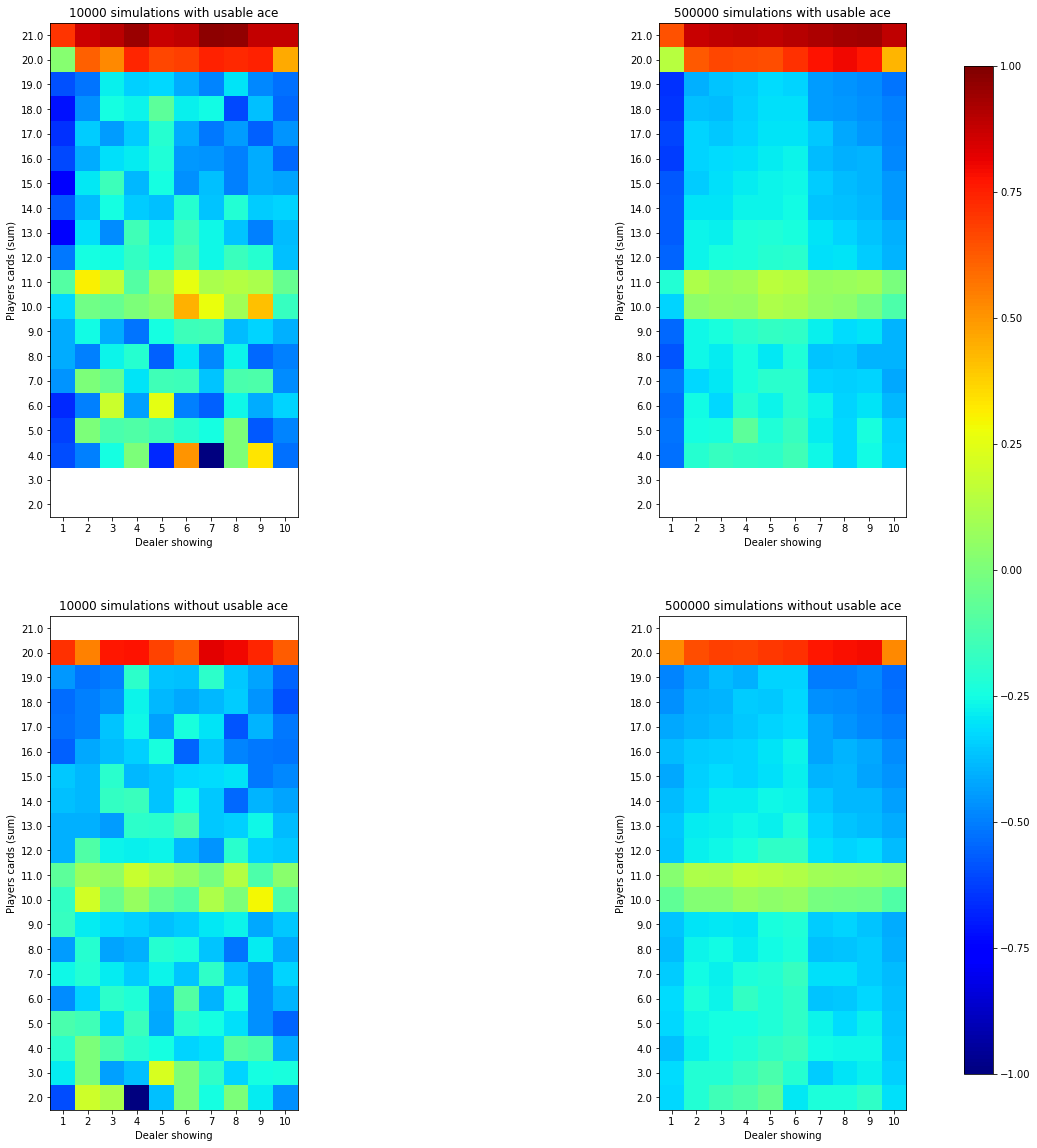

In [298]:
import matplotlib.pyplot as plt
plt.subplots(ncols=2,nrows=1,figsize=(20,20),sharey='row')
#plt.subplots_adjust(wspace = 1)

plt.subplot(2,2,1)
plt.imshow(X=prob_reward_matrix_1ace,cmap='jet', origin='lower',vmin=-1, vmax=1)
plt.xticks( np.arange(10),[1,2,3,4,5,6,7,8,9,10])
plt.yticks( np.arange(1,21), np.linspace(num=20, start= 2, stop= 21))
plt.ylabel('Players cards (sum)')
plt.xlabel('Dealer showing')
plt.ylim(0.5,20.5) # removing nan
plt.title('10000 simulations with usable ace')

#plt.tight_layout()

plt.subplot(2,2,2)
plt.imshow(X=prob_reward_matrix_5ace,cmap='jet', origin='lower', vmin=-1, vmax=1)
plt.xticks( np.arange(10),[1,2,3,4,5,6,7,8,9,10])
plt.yticks( np.arange(1,21), np.linspace(num=20, start= 2, stop= 21))
plt.ylabel('Players cards (sum)')
plt.xlabel('Dealer showing')
plt.ylim(0.5,20.5) # removing nan
plt.title('500000 simulations with usable ace')


plt.subplot(2,2,3)
plt.imshow(X=prob_reward_matrix_1noace,cmap='jet', origin='lower',vmin=-1, vmax=1)
plt.xticks( np.arange(10),[1,2,3,4,5,6,7,8,9,10])
plt.yticks( np.arange(1,21), np.linspace(num=20, start= 2, stop= 21))
plt.ylabel('Players cards (sum)')
plt.xlabel('Dealer showing')
plt.ylim(0.5,20.5) # removing nan
plt.title('10000 simulations without usable ace')

#plt.tight_layout()

plt.subplot(2,2,4)
plt.imshow(X=prob_reward_matrix_5noace,cmap='jet', origin='lower', vmin=-1, vmax=1)
plt.xticks( np.arange(10),[1,2,3,4,5,6,7,8,9,10])
plt.yticks( np.arange(1,21), np.linspace(num=20, start= 2, stop= 21))
plt.ylabel('Players cards (sum)')
plt.xlabel('Dealer showing')
plt.ylim(0.5,20.5) # removing nan
plt.title('500000 simulations without usable ace')
cax = plt.axes([.85, 0.15, 0.02, 0.7])
plt.colorbar(cax=cax)

plt.show()

# b)

$$ \text{Average reward} = \frac{\sum_{i=1}^{N} \text{episode}_i}{N} $$

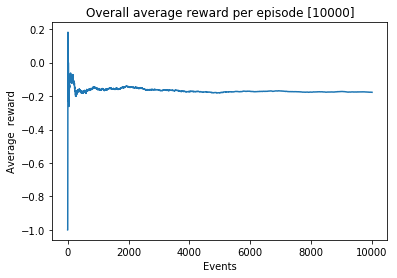

Average reward for event 10000 : -0.177


In [303]:
rewards_per_trial = player_hands_10000.sum(axis=0)
averages = []
for n,_ in enumerate(rewards_per_trial):
    reward = rewards_per_trial[0:(n+1)].sum()
    n = n+1
    averages.append(reward/n)
plt.plot(range(0,len(averages)), averages)   
plt.title('Overall average reward per episode [10000]')
plt.xlabel('Events')
plt.ylabel('Average  reward')
plt.show()
print('Average reward for event %d : %.3f' %(len(averages),averages[-1]))

In [304]:
rewards_per_trial = player_hands_500000.sum(axis=0)
averages = []
for n,_ in enumerate(rewards_per_trial):
    reward = rewards_per_trial[0:(n+1)].sum()
    n = n+1
    averages.append(reward/n)

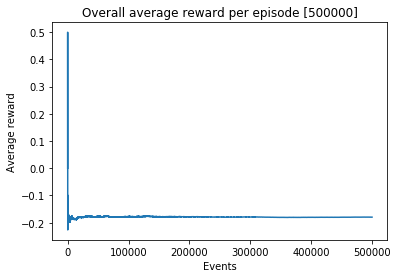

Average reward for event 500000 : -0.180


In [305]:
plt.plot(range(0,len(averages)), averages)
plt.title('Overall average reward per episode [500000]')
plt.xlabel('Events')
plt.ylabel('Average reward')
plt.show()
print('Average reward for event %d : %.3f' %(len(averages),averages[-1]))

## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

**ANSWER**

## a)

In [130]:
value_function = {}  #State Value Function matrix  Vπ(s) = Eπ [Gt|st = s]
action_value =   {} #Action value function - Qπ(s,a)
Num_states = {} #Number os times a state has been observed
n_s_a = {} #  N(st,at)  is the number of times action  'a'  has been selected from state 's' . 

state = np.arange(2,22) #player cards
for state in state:
    #creating dictionaries for every value
    for croupier in range(1,11):
        #for ace in [True,False]:
        for ace in [0,1]:
            Num_states[(state,croupier,ace)]= 0 
            value_function[(state,croupier,ace)] = 0  #ad usable ace
            #Action 1 ; #Action 2
            action_value[(state,croupier,ace),2] = 0 ; action_value[(state,croupier,ace),1] = 0
            n_s_a[(state,croupier,ace),2] = 0 ; n_s_a[(state,croupier,ace),1] = 0

In [131]:
def online_avg_action(state, action, reward):  #state is a tuple(3 values) / action an integer[1 or 2] / rewards integer (-1,0,1)
    try: 
        return (reward/n_s_a[state,action]) + ((n_s_a[state,action]-1)/n_s_a[state,action]) * action_value[state,action]
    except ZeroDivisionError:
        return reward

def online_avg_state(state, reward):  #state is a tuple(3 values) / action an integer[1 or 2] / rewards integer (-1,0,1)
    try: 
        return (reward/Num_states[state]) + ((Num_states[state]-1)/Num_states[state]) * value_function[state]
    except ZeroDivisionError:
        return reward

In [132]:
def epsilon(state, N0 = 100):
    action = compare_state(state)
    not_action = {1:2, 2:1}
    prob = 1 - (N0/(N0 + Num_states[state])) 
    #print('prob: ',prob)
    if np.random.binomial(size=1, n=1, p= prob): 
        return action
    else: 
        return not_action[action]    

In [133]:
import random
def compare_state(state): 
    if action_value[state,1] > action_value[state,2]:
        return 1
    elif action_value[state,1] == action_value[state,2]:
        return random.randint(1,2)
    else: 
        return 2

In [134]:
def play_blackjack():
    game = Blackjack()
    states = []
    actions = []
    state = game.deal()
    while True:
        states.append(state)
        action = epsilon(state, N0=100)
        actions.append(action)
        (player, croupier, usable_ace),reward,end_game = game.step(action)
        state = (player, croupier, usable_ace)
        if end_game:
            break
    return states, reward , actions
#for i in range(20): print(play_blackjack())

In [135]:
def MDP(iterations=10):
    rewards_per_trial = []
    averages = []
    for _ in range(iterations):
        states, reward, actions = play_blackjack()
        rewards_per_trial.append(reward)
        for n,state in enumerate(states):
            value_function[state] = online_avg_state(state,reward)
            action_value[state,actions[n]] = online_avg_action(state,actions[n],reward)
            n_s_a[state,actions[n]] += 1
            Num_states[state] += 1
    
    #To plot 2.b
    for n,_ in enumerate(rewards_per_trial):
        reward = sum(rewards_per_trial[0:(n+1)])
        n = n+1
        averages.append(reward/n)
    plt.plot(range(0,len(averages)), averages)
    plt.title('Overall average reward per episode [%d]' %len(averages))
    plt.xlabel('Events')
    plt.ylabel('Average  reward')
    plt.show()
    print('Average reward for event %d : %.3f' %(len(averages),averages[-1]))


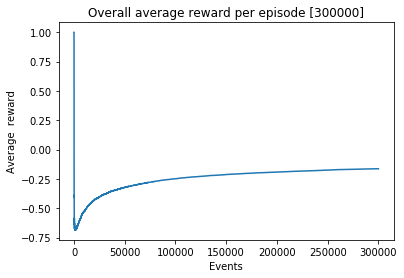

Average reward for event 300000 : -0.163


In [136]:
MDP(iterations=300000)

In [137]:
value_state_matrix_ace = np.zeros((21,10))
value_state_matrix_no_ace = np.zeros((21,10))

In [138]:
#To convert dict in np.matrix
results = list(value_function.items())
for (player,croupier, true_ace),avg_reward in results: #true_ace 0 is with usable ace tru // 1 is wihtout
    row = player - 1
    column = croupier - 1
    if true_ace == 0: 
        value_state_matrix_ace[row][column] = avg_reward
    else:
        value_state_matrix_no_ace[row][column] = avg_reward
    

<function matplotlib.pyplot.show(*args, **kw)>

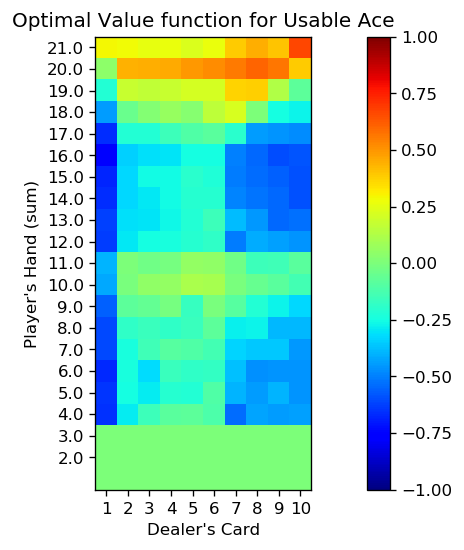

In [139]:
plt.figure(figsize=(12,5),dpi=120);
plt.title("Optimal Value function for Usable Ace")
plt.ylabel("Player's Hand (sum)"); plt.xlabel("Dealer's Card")
plt.imshow(X=value_state_matrix_ace[:][:],cmap='jet', origin='lower',vmin=-1, vmax=1)
plt.xticks( np.arange(10),[1,2,3,4,5,6,7,8,9,10])
plt.yticks( np.arange(1,21), np.linspace(num=20, start= 2, stop= 21))
plt.colorbar()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

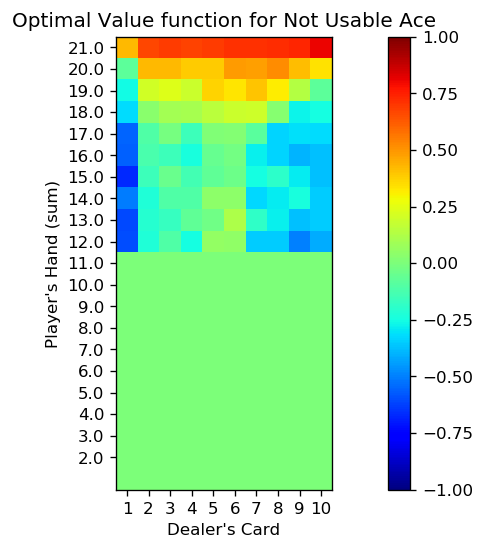

In [141]:
plt.figure(figsize=(12,5),dpi=120);
plt.title("Optimal Value function for Not Usable Ace")
plt.ylabel("Player's Hand (sum)"); plt.xlabel("Dealer's Card")
plt.imshow(X=value_state_matrix_no_ace[:][:],cmap='jet', origin='lower',vmin=-1, vmax=1)
plt.xticks( np.arange(10),[1,2,3,4,5,6,7,8,9,10])
plt.yticks( np.arange(1,21), np.linspace(num=20, start= 2, stop= 21))
plt.colorbar()
plt.show

In [142]:
action_state_matrix_ace = np.zeros((2,21,10)) #first number is the 3 dimension. In this case is for reward the action (step or hit)
action_state_matrix_no_ace = np.zeros((2,21,10))
#To convert dict in np.matrix
results = list(action_value.items())
for ((player,croupier, true_ace),action), avg_reward in results: #true_ace 0 is with usable ace tru // 1 is wihtout
    row = player - 1
    column = croupier - 1
    action = action - 1 #index 0 is hit, index 1 is stick
    if true_ace == 0: 
        action_state_matrix_ace[action][row][column] = avg_reward
    else:
        action_state_matrix_no_ace[action][row][column] = avg_reward

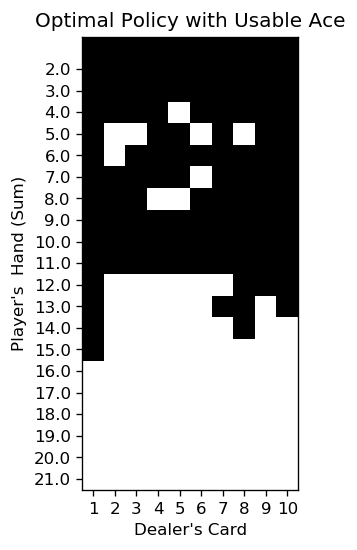

Black: Hit
White: Stick


In [143]:
policy = np.zeros((21,11))
for ps in range(21):
    for dc in range(10):
        policy[ps,dc] = np.argmax(action_state_matrix_ace[:,ps,dc])

plt.figure(figsize=(12,5),dpi=120);
plt.title("Optimal Policy with Usable Ace")
plt.ylabel("Player's  Hand (Sum)"); plt.xlabel("Dealer's Card")
plt.xticks( np.arange(10),[1,2,3,4,5,6,7,8,9,10])
plt.yticks( np.arange(1,21), np.linspace(num=20, start= 2, stop= 21))
plt.xlim(-0.5,9.5)
plt.imshow(policy,cmap='gray')
plt.show()
print('Black: Hit\nWhite: Stick')

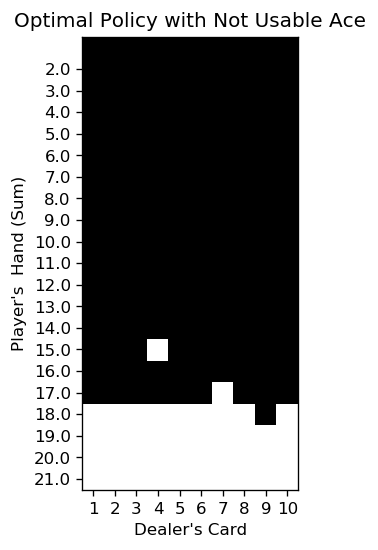

Black: Hit
White: Stick


In [224]:
policy = np.zeros((21,11))
for ps in range(21):
    for dc in range(10):
        policy[ps,dc] = np.argmax(action_state_matrix_no_ace[:,ps,dc])

plt.figure(figsize=(12,5),dpi=120);
plt.title("Optimal Policy with Not Usable Ace")
plt.ylabel("Player's  Hand (Sum)"); plt.xlabel("Dealer's Card")
plt.xticks( np.arange(10),[1,2,3,4,5,6,7,8,9,10])
plt.yticks( np.arange(1,21), np.linspace(num=20, start= 2, stop= 21))
plt.imshow(policy,cmap='gray')
plt.xlim(-0.5,9.5)
plt.show()
print('Black: Hit\nWhite: Stick')

## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

#### a)
When we compare the three policies (the human control policy, naive policy, and the optimal control policy) we could observe that the one that performed the best is the monte carlo control policy. The human policy resulted in a overall average reward of -0.40. The naive policy resulted in a overall average reward of **XXXX**. The optimal monte carlo control policy  with 300000 permutations resulted in a overall average reward of -0.163, much greater than any of the other policies.
The optimal control policy had the greatest average reward as consequence of the several iterations of evaluating and improving the policy. The final updated policy is the one that maximize the reward gor each possible state.

The human policy could have been more succesfull than the naive policy with more trails. In a sense the human policy is sensible to learning, trying to 'realize' what is the best policy. The naive policy reached a 'steady value' given certain amount of trials. In this way, we could think that the naive policy reached the optimal value state for the particular policy of Hitting is the value was below 20.

#### (b)
The answers to this question would depend on the amount of time (or number of iterations) to improve my policy. With an infinite amout of time both Monte Carlo optimal control policy would converge to the optimal policy (being this the same if we knew the full MDP), but if we do not hava an infite time the MDP would result in a better policy.   

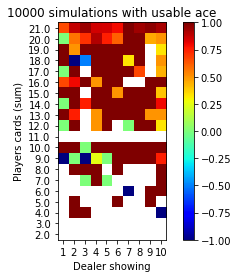

In [290]:
def play_blackjack2():
    game = Blackjack()
    states = []
    actions = []
    state = game.deal()
    while True:
        states.append(state)
        if state[0] <= 19:
            action = 1
        else: 
            action = 2
        actions.append(action)
        (player, croupier, usable_ace),reward,end_game = game.step(action)
        state = (player, croupier, usable_ace)
        if end_game:
            break
    return states, reward , actions

In [293]:
game.deal()

(17, 8, False)